# Title

## Introduction

PLAICraft is a Minecraft server run by the Pacific Laboratory for Artificial Intelligence (PLAI). They are a cutting-edge research group who are based in the Department of Computer Science at The University of British Columbia. Their objective is to advance Artificial Intelligence to behave more humanly by collecting data from players, such as how they interact, how they talk, and how they behave.

For this project, we have been tasked with answering a few questions to help recruit more players who may perform signnificant contributions to the collection of data.

### Question

Our group will try to answer the following question: **How does age predict the number of hours played?**

Our variable of interest is `played_hours`, and our explanatory variable will be `age`. We hypothesize that `age` will indicate higher average game hours. We hypothesize that people of similar ages will have similar interests, motivations, and similar amounts of free time. Therefore, people of similar age will play a similar amount of Minecraft. We will isolate our predictor variable and interest variable columns in the `players.csv` dataset and look for correlations between predictors and interest variables.

Since no column from the `sessions.csv` dataset will be useful in answering our question, we will omit that dataset, and not use any of its variables.

### Data Description

For this project, we will only be using the Players dataset. However, here's an overview of the two datasets we have:

The dataset `players.csv` consists of $9$ variables and $196$ observations. This dataset contains a list of every registered player along with the data they provided when registering, with each observation being a unique player. The second dataset `sessions.csv` consists of $5$ variables and $1535$ observations. Each observation is a play session of a given player.

#### Players Dataset

The $9$ variables of the Players dataset consist of the following:
- `experience` (chr type): Self-declared skill level of the player - one of `Amateur`, `Beginner`, `Regular`, `Veteran`, or `Pro` (with `Amateur` being the least experienced, and `Pro` being the most experienced)
- `subscribe` (lgl type): Indicates whether the player is subscribed to the game or not - one of `True` or `False`
- `hashedEmail` (chr type): A hashed encryption of the player's email - it can be unhashed using a key
- `played_hours` (dbl type): Total hours played by the player (in **hours**)
- `name` (chr type): Name of the player
- `gender` (chr type): Gender of the player
- `age` (dbl type): Age of the player (in **years**)
- `individialID` (lgl type): ID of the individual player (unavailable/**NA**)
- `organizationName` (lgl type): Organization of the player (unavailable/**NA**)

This data seems to have been obtained in several ways: demographic and account data was likely collected upon each player making their account. The `played_hours` column was likely logged over time as the server recorded each player's play sessions. This data is untidy because some columns do not contain any data. The `individualID` and `organizationName` columns contain no data, and the `hashedEmail` column has no meaning unless used with the sessions data frame.

#### Sessions Dataset

The $5$ variables of the Sessions dataset consist of the following:
- `hashedEmail` (chr type): A hashed encryption of the player's email - it can be unhashed using a key
- `start_time` (chr type): The data and time of the start of the session (**DD**/**MM**/**YYYY** and **time** format)
- `end_time` (chr type): The date and time of the end of the session (**DD**/**MM**/**YYYY** and **time** format)
- `original_start_time` (dbl type): UNIX time at the start of the session (**seconds** from 00:00:00 UTC on Thursday, 1 January 1970)
- `original_end_time` (dbl type): UNIX time at the end of the session (**seconds** from 00:00:00 UTC on Thursday, 1 January 1970)

This data seems to have been obtained from the game server every time a player logged on to play. The server has recorded the timing of the session, in several different formats. The data is not tidy, because the `start_time` and `end_time` columns contain multiple observations, with the date and the time formatted differently. Again, the `hashedEmail` is not meaningful, but it can be used to match players to their play sessions.

## Methods & Results

In [79]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)
#

First were going to load in our 2 data sets. The first one being the players data set which contains all the information about the players themselves, and the second one being the sessions data set which contains the information about the session times. 

In [80]:
# Read players.csv
players <- read_csv("https://drive.google.com/uc?export=download&id=1Mw9vW0hjTJwRWx0bDXiSpYsO3gKogaPz")

# Read sessions.csv
sessions <- read_csv("https://drive.google.com/uc?export=download&id=14O91N5OlVkvdGxXNJUj5jIsV5RexhzbB")

Rows: 196 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, age
lgl (3): subscribe, individualId, organizationName

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Since the only variables were dealing with to answer our question is played_hours and age, where going to use the select function to create a new data frame with only the variables we need.

In [81]:
set.seed(1234)

players_select <- players |>
    select(played_hours, age)

players_select

played_hours,age
<dbl>,<dbl>
30.3,9
3.8,17
0.0,17
⋮,⋮
0.0,17
2.3,17
0.2,91


Now we're going to plot Age with respect to played_hours to get a general idea of our plot and to see which prediction method to use. 

In [90]:
# Age Plot

demographics_playtime_plot <- players_select |>
ggplot(aes(x=age, y=played_hours)) +
geom_point() +
scale_x_log10() +
scale_y_log10() +
labs(x="Player Age",
     y="Total Playtime (Hours)",
    title=" Figure 1: Player Age vs. Total Playtime") |>
    legend("topright",
       legend = c("y = x^2", "y = x^3"),
       col = c("blue", "red"),
       lwd = 2)
demographics_playtime_plot

demographics_playtime_plot2 <- players_select |>
ggplot(aes(x=age, y=played_hours)) +
labs(x= "Player Age",
     y="Total Playtime (Hours)",
    title=" Figure 2: Player Age vs. Total Playtime (unscaled)") +
geom_point()
demographics_playtime_plot2

# Age Average Plot

age_averages <- players_select |>
    group_by(age) |>
    summarize(avg_total_playtime = mean(played_hours))

age_averages

age_avgs_plot <- age_averages |>
    ggplot(aes (x = age, y = avg_total_playtime)) +
    scale_x_log10() +
    scale_y_log10() + 
    labs(x = "Player Age", y = "Average Playtime (Hours)", title = "Age and Playtime") +
    geom_line() 

age_avgs_plot


age_averages <- players_select |>
    group_by(age) |>
    summarize(avg_total_playtime = mean(played_hours))


age_playtime_rawandaverage <- ggplot() +
scale_x_log10() +
scale_y_log10() +
labs(x= "Player Age",
     y="Total Playtime (Hours)",
    title=" Figure 1: Player Age vs. Total Playtime") +
geom_point(data = players_select, aes(x = age, y = played_hours), color = "blue", size = 3) +
geom_line(data = age_averages, aes(x = age, y = avg_total_playtime), color = "red", size = 1)

age_playtime_rawandaverage


ERROR: Error in xy.coords(x, y, setLab = FALSE): 'x' and 'y' lengths differ


The "Player Age vs. Total Playtime" plot shows us that the majority of players are around age 20, and that most players play for 10 hours or less. There is no clear linear correlation between player age and playtime. A few age outliers were likely not being truthful in the survey, so we will have to deal with outliers.
We conclude that KNN regression be the best predictive model to use in predicting hours played from the predictive variable "age".

We think KNN regression will work best to analyze our question, based on what the first graph shows. Since there is no visible linearity between age and playtime, it's best to use KNN regression to predict playtime's relation to age. However, KNN predictions get less meaningful as we approach the higher end of the data set, when there are fewer nearby datapoints. We will be making the assumptions that there are certain outliers that may be excluded, since it seems to me that some people may not be honest on the intake surveys. We will compare and select the best number of neighbors using a vfold selection process. We will split the data into 2 sets, one for testing and one for training. I will recommend a 75-25 training-testing split, because we want plenty of training data to do vfold selection and 75 is the higherst proportion we have used in class thus far. The training set will be further split into 5 to facilitate the selection of the right number of neighbors, and the right model will be selected based on RMSE.

First step is going to be creating our training and testing data. We also want to make sure that were setting a seed so that its not different everytime we run it.

In [89]:
set.seed(2000)


#initial split
players_split <- initial_split(players_select, prop = .75, strata = played_hours)

# Training data
players_training <- training(players_split)
#Testing Data
players_testing <- testing(players_split)

players_training
players_testing

played_hours,age
<dbl>,<dbl>
0.0,17
0.1,21
0.0,17
⋮,⋮
32.0,22
1.7,17
2.3,17


played_hours,age
<dbl>,<dbl>
0.0,19
0.1,17
0.0,17
⋮,⋮
0,17
0,17
0,17


Next step is going to be performing cross validation on our data to determine which K value we should use for our prediction. To achieve this were going to use our k-nn algorithm for regression. Were going to do this by creating our recipe and following the steps get our K value. 

In [88]:

players_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("regression")


players_recipe <- recipe(played_hours ~ age, data = players_select)

players_vfold <- vfold_cv(players_training, v = 5, strata = played_hours)

players_workflow <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(players_spec)

gridvals <- tibble(neighbors = seq(1,100, by = 1))

players_results <- players_workflow |>
    tune_grid(resamples = players_vfold, grid = gridvals) |>
    collect_metrics()
players_results

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,rmse,standard,9.81839261,5,0.83861118,Preprocessor1_Model001
1,rsq,standard,0.04301136,5,0.02729753,Preprocessor1_Model001
2,rmse,standard,8.95055121,5,1.25352519,Preprocessor1_Model002
⋮,⋮,⋮,⋮,⋮,⋮,⋮
99,rsq,standard,0.03372960,5,0.01852543,Preprocessor1_Model099
100,rmse,standard,8.16295066,5,1.53041560,Preprocessor1_Model100
100,rsq,standard,0.04000237,5,0.01932489,Preprocessor1_Model100


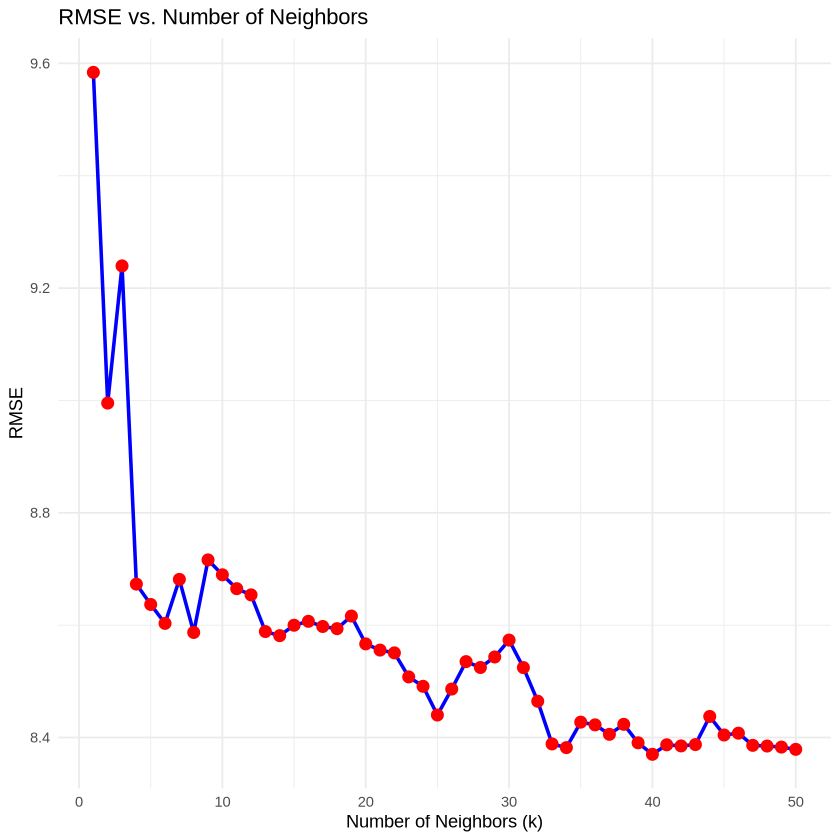

In [87]:

rmse_data <- players_results |>
  filter(.metric == "rmse")

rmse_plot <- rmse_data |>
  ggplot(aes(x = neighbors, y = mean)) +  
  geom_line(color = "blue", size = 1) +         
  geom_point(color = "red", size = 3) +         
  labs(
    x = "Number of Neighbors (k)",   
    y = "RMSE",                      
    title = "RMSE vs. Number of Neighbors"
  ) +
  theme_minimal()

rmse_plot


In [86]:

players_min <- players_results |>
    filter(.metric == "rmse") |>
    slice_min(mean, n=1)
players_min

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
40,rmse,standard,8.370081,5,1.351195,Preprocessor1_Model40


In [85]:
set.seed(1234) # DO NOT REMOVE

k_min <- players_min |>
          pull(neighbors)

players_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = k_min) |>
          set_engine("kknn") |>
          set_mode("regression")

players_best_fit <- workflow() |>
          add_recipe(players_recipe) |>
          add_model(players_best_spec) |>
          fit(data = players_training)

players_summary <- players_best_fit |>
           predict(players_testing) |>
           bind_cols(players_testing) |>
           metrics(truth = played_hours, estimate = .pred)

players_summary

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,54.91450195
rsq,standard,0.09299815
mae,standard,16.77860000


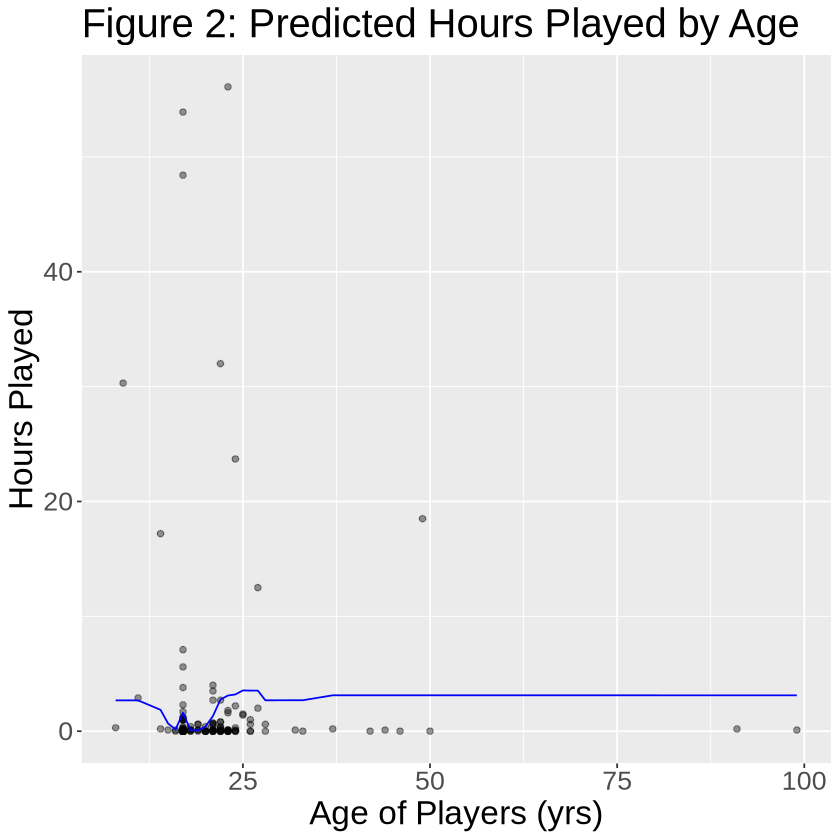

In [84]:
players_preds <- players_best_fit |>
                predict(players_training) |>
                bind_cols(players_training)

age_plot <- ggplot(players_preds, aes(x = age, y = played_hours)) +

            geom_point(alpha = 0.4) +
            xlab("Age of Players (yrs)") +
            ylab("Hours Played") + 
            geom_line(data = players_preds, aes(x = age, y = .pred), color = "blue") +
            ggtitle("Figure 2: Predicted Hours Played by Age") +
            theme(text = element_text(size = 20))

age_plot

In [83]:
highest_age <- players_best_fit |>
           predict(players_testing) |>
           bind_cols(players_testing) |>
           slice_max(.pred)

highest_age

.pred,played_hours,age
<dbl>,<dbl>,<dbl>
3.55,0,25


## Discussion

The age with the highest predicted playtime in hours is age 25. The model predicts that a 25 year old will play 3.55 hours.
Very young people are predicted to play around 3 hours as well, with the line flattening out as the participants get younger.
Overall, teenagers have a very lowe average, with a spike in predicted play hours around age 15. Most of the participants are teenagers, and most of those participants have not played much. We believe our model would be more effective with more participants above the age of 25. At higher ages, the predictor model is using the same few datapoints as its nearest neighbors, causing the prediction to appear as a horizontal line on the graph. Since the data is clustered and heavily favors the ~15 to 25 age bracket, the model shows more variation there. 

This is no what we expected to find. We expected teenagers to have a higher average, since we believe younger people have more free time to play and likely have a higher interest in minecraft. It's possible that fewer older participants would be interested in this kind of study, and those who are interested are also interested enough to actually play slightly more on average. We think more young people were invited to be part of PLAICraft, and many signed up even though few actually put in hours.

We think this finding will be able to help researchers because they know that of the participants they are able to interest in signing up, those around 25 years old are most likely to put more hours into the server. If the researchers were more selective and set a higher bar to get into the study, fewer teenagers would join and not actually play. Those that would be willing to do the work to sign up and participate would actually care more, and would play more hours. We also think the data shows that researchers should reach out more to older age groups to get a more balanced spread of participants.

This could lead to several future questions, such as: How can age predict experience level? This might be interesting because it seems from our finding that teens are not predicted to play as much, so perhaps younger people have a lower average experience level.
Researchers could also investigate the question of gender and hours played. This might give insight into what groups are putting the most time into the server and help researchers find more engaged participants.


## References